In [1]:
using Revise

In [2]:
using DrWatson
@quickactivate :LowRankVlasov1D1V

┌ Info: Precompiling LowRankVlasov1D1V [a019a79c-4ebf-43b5-8935-89dea3e70e6f]
└ @ Base loading.jl:1423


In [103]:
using SparseArrays
using CairoMakie
using LinearAlgebra
using ProgressMeter
using ProfileView

In [147]:
domain = make_domain(nx=128, x_min=0.0, x_max=2π, nv=128, v_min=-10.0);
@show size(domain.v)

f1(x, v) = begin
    ρ(x) = 0.0 + exp(-(x-3)^2/.3)
    #ρ(x) = 1.0 + 0.5 * cos(x)
    M(v, u, T) = 1 / (√(2π*T)) * exp(-(v - u)^2 / 2T)
    #M(v, u, T) = 1

    ρ(x) * M(v, 0.5, 50)
end

f0(x, v) = f1(x - 0.2*v, v)

@show size(domain.x)
η0(x) = 1.0


size(domain.v) = (128,)
size(domain.x) = (128,)


η0 (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


nt = Int(round(T / Δt)) = 100
  3.006592 seconds (3.72 M allocations: 1.054 GiB, 3.27% gc time)


20-element Vector{Float64}:
 -9.633108669623098
 -8.470063374407646
 -5.25540280954569
 -4.384159958739961
 -3.5634482602017123
 -2.767516391151998
 -1.976784414360934
 -1.172889234752662
 -0.3571101528877081
 -0.10280428018447707
  0.42828346721344074
  0.9356095991183545
  1.522391768996492
  2.339220402777272
  3.169824230732412
  3.9283217955302874
  4.563852212491821
  5.285070914926541
  6.807056551864758
  9.161018498841605

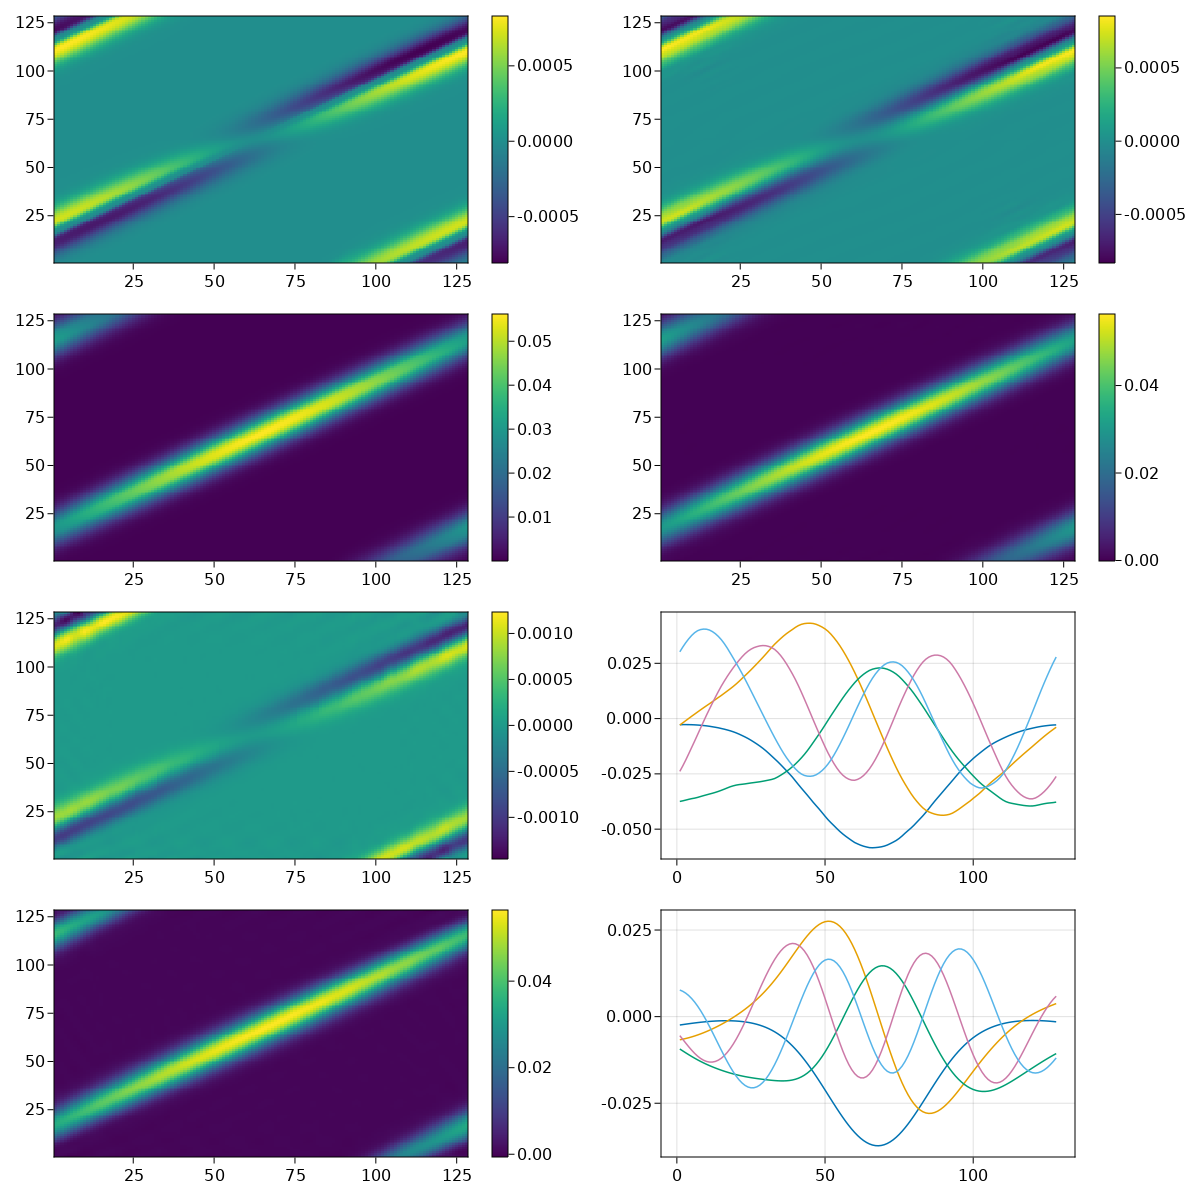

In [360]:
r = 20
ft_sim = full_tensor_initial_condition(domain, f0, η0, q=0);
ft_trunc_sim = full_tensor_initial_condition(domain, f0, η0, q=0);
lr_sim = initial_condition(domain, f0, η0, r=r, q=0);

lr_f_0 = expand_f(lr_sim)

X_0, S_0, V_0 = lr_sim.X, lr_sim.S, lr_sim.V

T = 0.20
t = 0.0
Δt = 0.002
@show nt = Int(round(T / Δt))
prog = Progress(nt)

@time for i in 1:nt
    step!(ft_sim, Δt)
    take_truncated_step!(ft_trunc_sim, Δt, r=r)
    step!(lr_sim, Δt)
    next!(prog)
end

ft_f = ft_sim.f
lr_f = expand_f(lr_sim)

step!(ft_sim, Δt)
take_truncated_step!(ft_trunc_sim, Δt, r=r)
step!(lr_sim, Δt, debug=true)

ft_df = ft_sim.f - ft_f
lr_df = expand_f(lr_sim) - lr_f

F = svd(ft_df)
ft_lowrank_df = F.U[:, 1:r] * Diagonal(F.S[1:r]) * F.Vt[1:r, :]

K = lr_sim.X * lr_sim.S
L = lr_sim.V * lr_sim.S'

fig = Figure(resolution=(1200, 1200))
ax = Axis(fig[1, 1])
hm = heatmap!(ax, ft_df)
Colorbar(fig[1, 2], hm)
ax = Axis(fig[1, 3])
hm = heatmap!(ax, ft_lowrank_df)
Colorbar(fig[1, 4], hm)
ax = Axis(fig[2, 1])
hm = heatmap!(ax, ft_f)
Colorbar(fig[2, 2], hm)
ax = Axis(fig[2, 3])
hm = heatmap!(ax, ft_trunc_sim.f)
Colorbar(fig[2, 4], hm)
ax = Axis(fig[3, 1])
hm = heatmap!(ax, lr_df)
Colorbar(fig[3, 2], hm)

ax = Axis(fig[4, 1])
hm = heatmap!(ax, lr_f)
Colorbar(fig[4, 2], hm)

ax = Axis(fig[3, 3])
for i in 1:5
    lines!(ax, K[:, i])
end

ax = Axis(fig[4, 3])
for i in 1:5
    lines!(ax, L[:, i])
end
fig

# fig = Figure()
# ax = Axis(fig[1,1])
# hm = heatmap!(ax, (alloc_f64!(lr_sim.arena, :after_K, size(lr_f)) - lr_f_0) - ft_df)
# Colorbar(fig[1, 2], hm)
# ax = Axis(fig[2,1])
# after_S = alloc_f64!(lr_sim.arena, :after_S, size(lr_f))
# hm = heatmap!(ax, (after_S - lr_f_0) - ft_df)
# Colorbar(fig[2, 2], hm)
# ax = Axis(fig[1,3])
# after_L = (alloc_f64!(lr_sim.arena, :after_L, size(lr_f)))
# hm = heatmap!(ax, (after_L - lr_f_0) - ft_df)
# Colorbar(fig[1, 4], hm)
# fig

3-element Vector{Float64}:
 -7.5316417774731885
 -6.432137280042951
 -5.283811796314656

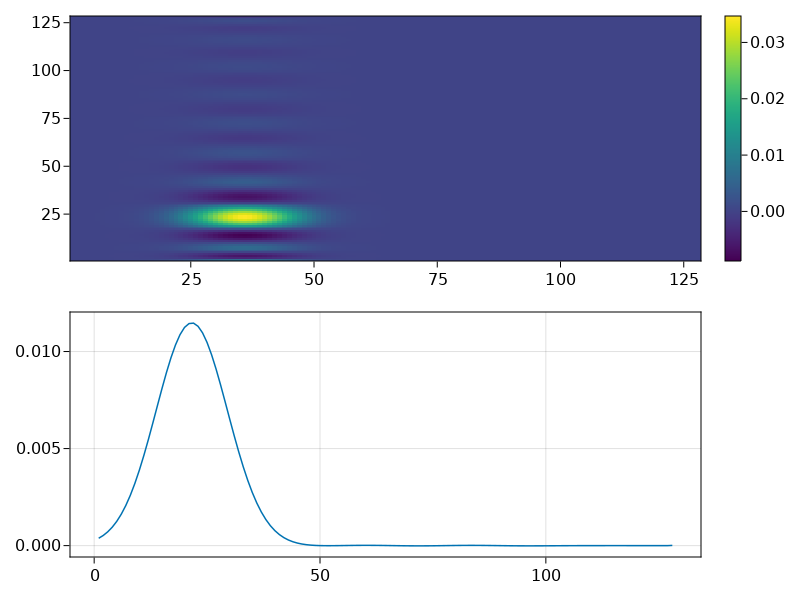

In [278]:
Il(l) = begin
    r = spzeros(size(R))
    r[l, l] = 1
    r
end

A¹ = LowRankVlasov1D1V.r_r_matrix_V(domain.v .* lr_sim.V, lr_sim.V, domain, r);
Λ, R = eigen(A¹)
K̂ = K * R

display(Λ[4:6])

fig = Figure()
# ax = Axis(fig[1, 1])
# for i in 1:10
#     lines!(ax, K̂[:, i])
# end

# display(Λ)

# ax = Axis(fig[1, 1])
# hm = heatmap!(ax, K̂[:, 4] * (R' * lr_sim.V')[:, 4]')
# Colorbar(fig[1, 2], hm)
# fig
ax = Axis(fig[1, 1])
hm = heatmap!(ax, K̂ * (Il(5)) * R' * lr_sim.V')
Colorbar(fig[1, 2], hm)
ax = Axis(fig[2, 1])
#hm = heatmap!(ax, K̂ * Il(10) * R' * lr_sim.V')
lines!(ax, K̂[:, 1])
fig

size(V̂) = (30, 128)


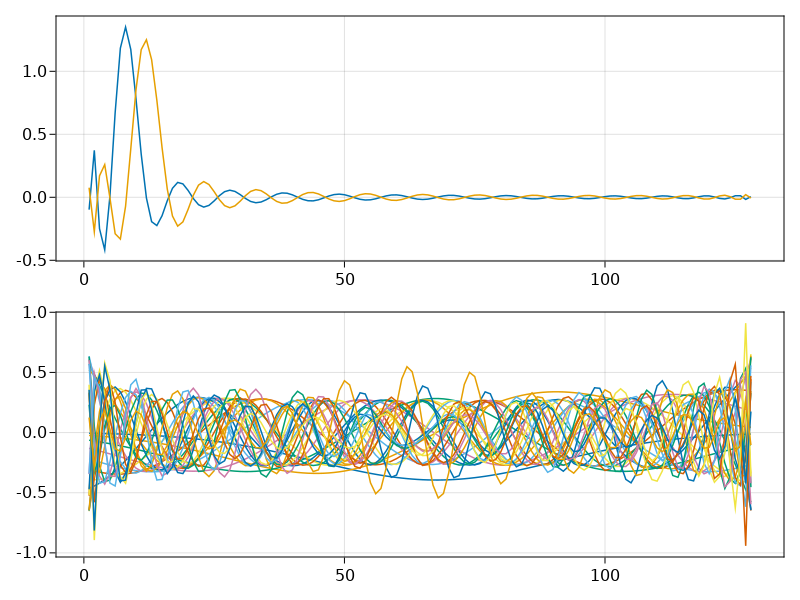

In [243]:
V̂ = R' * lr_sim.V'
@show size(V̂)

fig = Figure()
ax = Axis(fig[1, 1])
for i in 4:5
    lines!(ax, V̂[i, :])
end
ax = Axis(fig[2, 1])
for i in 1:r
    lines!(ax, lr_sim.V[:, i])
end
fig

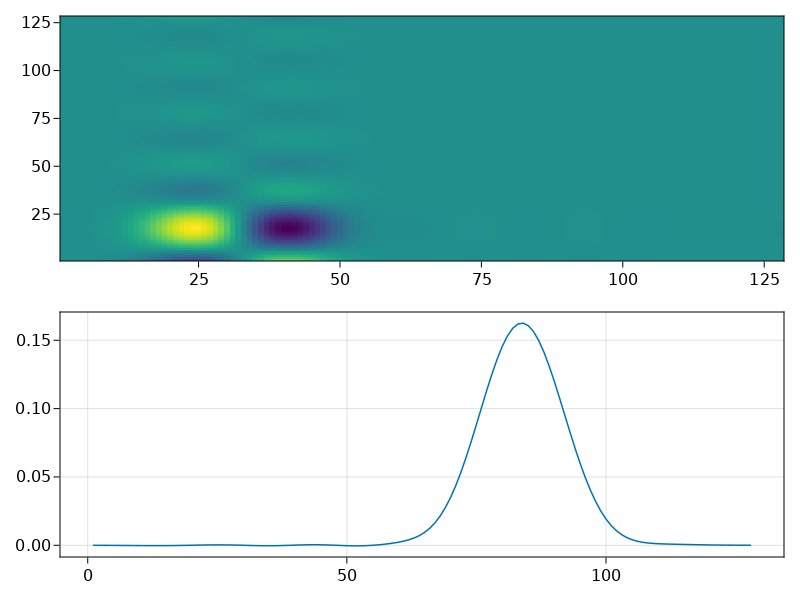

In [226]:
r = 10
ft_sim = full_tensor_initial_condition(domain, f0, η0, q=0);
ft_f_0 = ft_sim.f
step!(ft_sim, Δt)
ft_trunc_sim = full_tensor_initial_condition(domain, f0, η0, q=0);
lr_sim = initial_condition(domain, f0, η0, r=r, q=0);

F0 = svd(ft_f_0)
X0 = F0.U[:, 1:r]
S0 = Diagonal(F0.S[1:r])
V0 = Matrix(F0.V)[:, 1:r]

K0 = X0 * S0

Δf = ft_sim.f - ft_f_0
K1 = K0 + Δf * V0

A¹ =  LowRankVlasov1D1V.r_r_matrix_V(domain.v .* V0, V0, domain, r);
Λ, R = eigen(A¹)
K̂ = (K1 - K0) * R

fig = Figure()
ax = Axis(fig[1, 1])
heatmap!(ax, K̂ * Il(2) * R' * V0')
ax = Axis(fig[2, 1])
lines!(ax, (K0*R)[:, 8])
fig

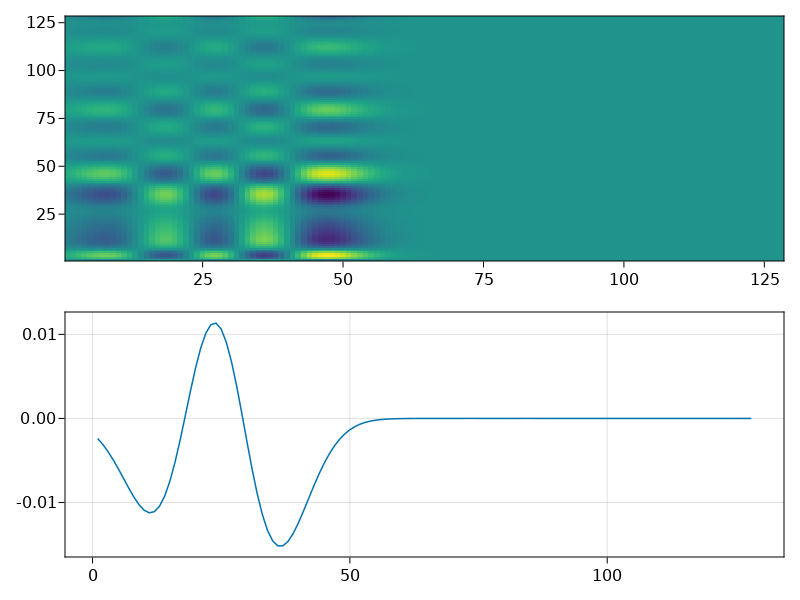

In [258]:
K = X_0 * S_0
A¹ =  LowRankVlasov1D1V.r_r_matrix_V(domain.v .* V_0, V_0, domain, r);
Λ, R = eigen(A¹)
K̂ = K * R
X̂, Ŝ = qr(K̂)
fig = Figure()
ax = Axis(fig[1, 1])
K̂ = X̂ * lr_sim.S
heatmap!(ax, K̂ * Il(5) * R' * lr_sim.V')
ax = Axis(fig[2, 1])
lines!(ax, K̂[:, 3])
fig

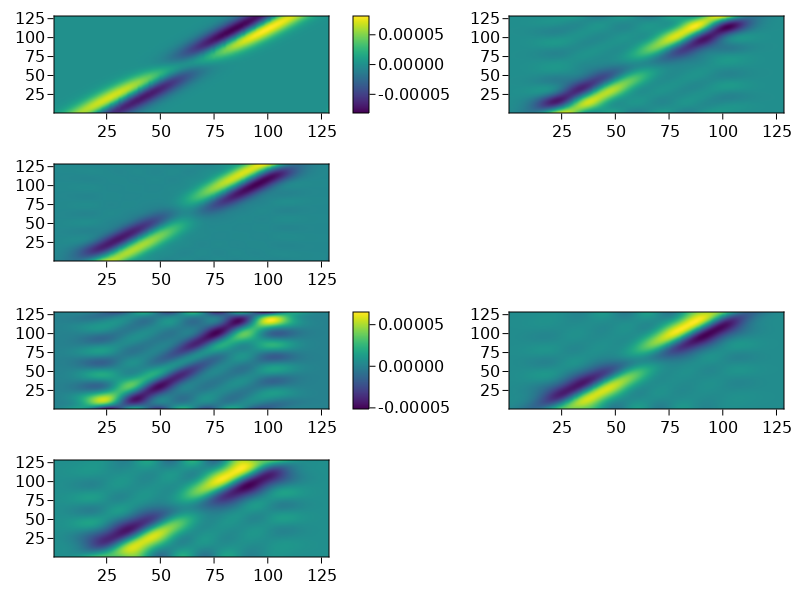

In [294]:
K_then_L_sim = initial_condition(domain, f0, η0, r=r, q=0);
L_then_K_sim = initial_condition(domain, f0, η0, r=r, q=0);
K_then_L_f_0 = expand_f(K_then_L_sim)
L_then_K_f_0 = expand_f(L_then_K_sim)

step!(K_then_L_sim, Δt);
step_L_then_K!(L_then_K_sim, Δt);

fig = Figure()
ax = Axis(fig[1,1])
hm = heatmap!(ax, (alloc_f64!(K_then_L_sim.arena, :after_K, size(lr_f)) - K_then_L_f_0))
Colorbar(fig[1, 2], hm)
ax = Axis(fig[2,1])
heatmap!(ax, lr_f_0 - alloc_f64!(K_then_L_sim.arena, :after_S, size(lr_f)))
ax = Axis(fig[1,3])
heatmap!(ax, lr_f_0 - alloc_f64!(K_then_L_sim.arena, :after_L, size(lr_f)))

ax = Axis(fig[3,1])
hm = heatmap!(ax, (alloc_f64!(L_then_K_sim.arena, :after_L, size(lr_f)) - L_then_K_f_0))
Colorbar(fig[3, 2], hm)
ax = Axis(fig[4,1])
heatmap!(ax, lr_f_0 - alloc_f64!(L_then_K_sim.arena, :after_S, size(lr_f)))
ax = Axis(fig[3,3])
heatmap!(ax, lr_f_0 - alloc_f64!(L_then_K_sim.arena, :after_K, size(lr_f)))
fig

size(X1') = (20, 128)
size(X) = (128, 20)
size(M) = (20, 20)
size(S0) = (20, 20)
size(A¹) = (20, 20)
size(A²) = (20, 20)
size(C¹) = (20, 20)
size(C²) = (20, 20)


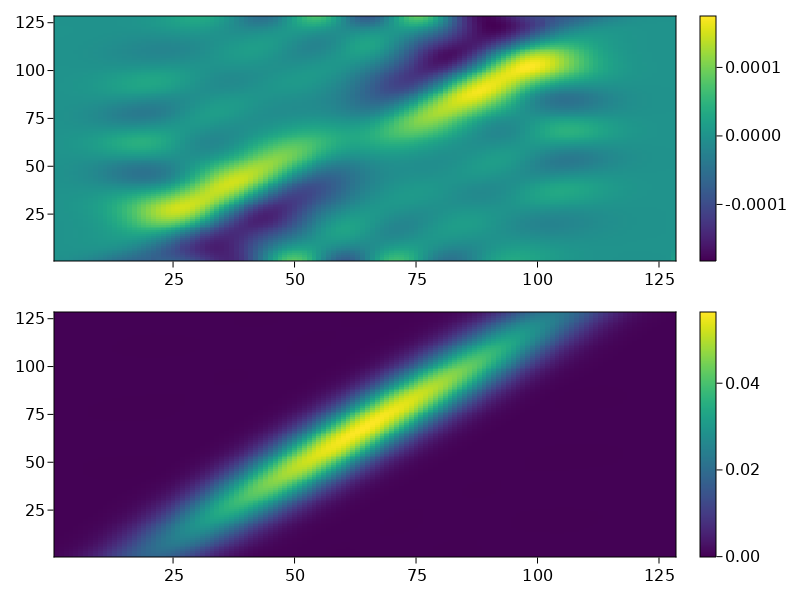

In [308]:
unconventional_sim = initial_condition(domain, f0, η0, r=r, q=0);
unconventional_f_0 = expand_f(unconventional_sim)

step_unconventional!(unconventional_sim, Δt);

fig = Figure()
ax = Axis(fig[1,1])
hm = heatmap!(ax, expand_f(unconventional_sim) - unconventional_f_0)
Colorbar(fig[1, 2], hm)
ax = Axis(fig[2,1])
hm = heatmap!(ax, expand_f(unconventional_sim))
Colorbar(fig[2, 2], hm)
fig